# Cleaning LendingClub loan data

The [dataset](https://www.kaggle.com/wendykan/lending-club-loan-data/data) is a csv file of loans that were accepted by Lending Club between June 2007 and December 2015. The final goal is to build a model that ranks 3-year loans by the expected ROI, and to examine how the predicted ROI varies based on which time span the model is trained on. This notebook focuses on cleaning the data in preparation for using classification and regression algorithms.

In [1]:
%pylab inline

from __future__ import division

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import diagnostics as diag

Populating the interactive namespace from numpy and matplotlib


In [2]:
import imp
imp.reload(diag)

<module 'diagnostics' from 'diagnostics.pyc'>

## Load the data

In [3]:
df = pd.read_csv('loan.csv', low_memory=False)
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Examine time dependence based on the date the loan was issued

In [4]:
# Convert the issued date to pandas time stamps
df['issue_d'] = pd.to_datetime(df['issue_d'])

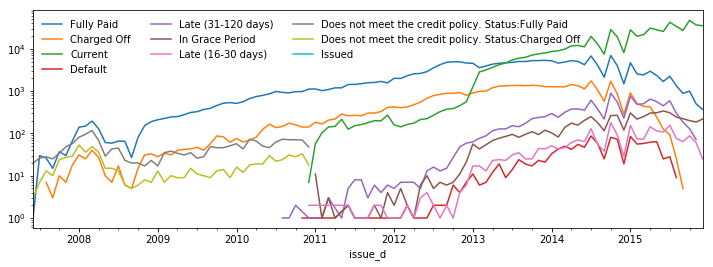

In [5]:
fig, ax = diag.plot_all_categories_in_column_as_time_series(df, 'loan_status')
ax.legend(ncol=3, frameon=False)

(<matplotlib.figure.Figure at 0x10990ec90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10984da90>)

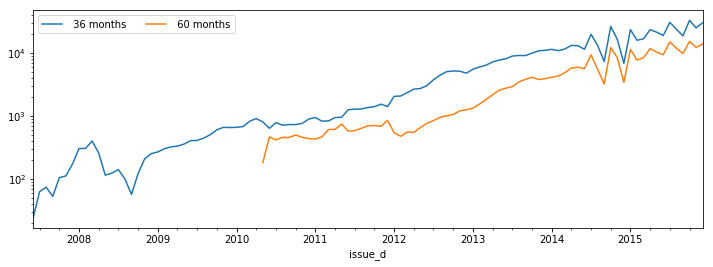

In [6]:
diag.plot_all_categories_in_column_as_time_series(df, 'term')

## Extract the binary target variable

We want to look at the 3-year loans that have either been 'Fully Paid' (0) or 'Charged Off' (1). 
 - The other categories in 'loan_status' are for loans still in progress, so we don't know their final state. 
 - There are also 5-year loans, but they have only been around for just over 5-years, so there is very little data on their final state.

In [7]:
# Only look at 3 year loans
df = df[df['term']==' 36 months']
df.drop('term', axis=1, inplace=True)
print df.shape

(621125, 73)


In [8]:
# Only loans with known final state.
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# 0 for good loan (common case). 1 for bad loan (rare case).
df['bad_loan'] = np.where(df['loan_status'].isin(['Charged Off']), 1, 0)

df.drop('loan_status', axis=1, inplace=True)

## Extract columns that will be used for building or evaluating the model

The columns include:
 - Target variable: 'bad_loan'
 - Features: Used for training the regression and classification algorithms. Only includes columns that are available at the time the loan was issued.
 - Columns for calculating the true ROI (recovered principle and recovered interest).

In [9]:
col_target = ['bad_loan']

col_borrower_info = [
    'grade', 'annual_inc', 'purpose', 'emp_length', 'addr_state', 'dti', 'home_ownership', 
    'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 
    'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

col_loan_info = ['loan_amnt', 'int_rate', 'installment']

# Information not to be used in classification or regression
col_extra = ['issue_d', 'total_rec_prncp', 'total_rec_int']

columns = col_target + col_borrower_info + col_loan_info + col_extra
clean_df = df[columns].copy()

In [10]:
print clean_df.shape
clean_df.head(3)

(196658, 27)


,bad_loan,grade,annual_inc,purpose,emp_length,addr_state,dti,home_ownership,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_amnt,int_rate,installment,issue_d,total_rec_prncp,total_rec_int
0,0,B,24000.0,credit_card,10+ years,AZ,27.65,RENT,0.0,1.0,NaN,3.0,0.0,13648.0,83.7,9.0,0.0,0.0,NaN,NaN,NaN,5000.0,10.65,162.87,2011-12-01,5000.0,861.07
2,0,C,12252.0,small_business,10+ years,IL,8.72,RENT,0.0,2.0,NaN,2.0,0.0,2956.0,98.5,10.0,0.0,0.0,NaN,NaN,NaN,2400.0,15.96,84.33,2011-12-01,2400.0,603.65
3,0,C,49200.0,other,10+ years,CA,20.00,RENT,0.0,1.0,35.0,10.0,0.0,5598.0,21.0,37.0,0.0,0.0,NaN,NaN,NaN,10000.0,13.49,339.31,2011-12-01,10000.0,2209.33


## Data munging
 - Fill missing data
 - Convert categorical data to ordinal data or cardinal data

In [11]:
# Number of non-null values for each column
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196658 entries, 0 to 887371
Data columns (total 27 columns):
bad_loan                      196658 non-null int64
grade                         196658 non-null object
annual_inc                    196658 non-null float64
purpose                       196658 non-null object
emp_length                    196658 non-null object
addr_state                    196658 non-null object
dti                           196658 non-null float64
home_ownership                196658 non-null object
delinq_2yrs                   196658 non-null float64
inq_last_6mths                196658 non-null float64
mths_since_last_delinq        86973 non-null float64
open_acc                      196658 non-null float64
pub_rec                       196658 non-null float64
revol_bal                     196658 non-null float64
revol_util                    196496 non-null float64
total_acc                     196658 non-null float64
collections_12_mths_ex_med    196

### Months since last delinquency
When NaN, there have been no delinquencies

<Container object of 3 artists>

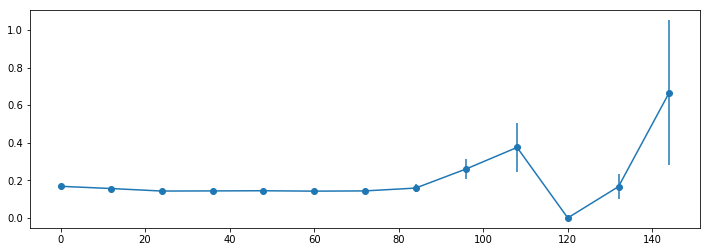

In [12]:
bins = np.arange(0, 200, 12)
ns, ps, pserr = diag.bin_prob_y(clean_df, 'mths_since_last_delinq', 'bad_loan', bins)

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(bins[:-1], ps, yerr=pserr, fmt='-o')

In [13]:
# If 'mths_since_last_delinq' is NaN, that means they have never had a delinquency.
# This is supported by the fact that the max value of deliquent accounts 'acc_now_delinq' is 0 for these borrowers.
# Impute this with the maximum value (should technically be infinity)

col = 'mths_since_last_delinq'
# # Get the NaN rows
# no_delinquencies = df[col].isnull()
# # Fill the NaN rows with the max value
# max_months = df[col].max()
# df.loc[no_delinquencies, col] = max_months
med = clean_df[col].median()
clean_df[col] = clean_df[col].fillna(med)
print med

33.0


### Total collections amount

How much has the borrower ever owed collections agencies. NaN means that no collections have ever been owed.

In [14]:
# Get the NaN rows and replace them with zeros
col = 'tot_coll_amt'
clean_df[col] = clean_df[col].fillna(0)

### Total current balance on all accounts

All money owed at the time of the loan application. This appears to be dominated by having a mortgage.

In [15]:
clean_df.groupby('home_ownership')['tot_cur_bal'].agg(['count', 'mean', 'median'])

,count,mean,median
home_ownership,,,
ANY,1,130923.000000,130923.0
MORTGAGE,70247,208686.030379,181421.0
NONE,35,115600.400000,65190.0
OTHER,40,98001.575000,42968.5
OWN,13175,89962.180569,35381.0
RENT,61516,45514.819966,29131.5


In [16]:
col = 'tot_cur_bal'
med = clean_df[col].median()
clean_df[col] = clean_df[col].fillna(med)
print med

66863.5


### Total revolving credit limit

Revolving credit limit (as in sum of all credit card limits, etc.).

In [17]:
clean_df['total_rev_hi_lim'].describe()

count    1.450140e+05
mean     2.836773e+04
std      2.923003e+04
min      0.000000e+00
25%      1.250000e+04
50%      2.090000e+04
75%      3.490000e+04
max      2.013133e+06
Name: total_rev_hi_lim, dtype: float64

In [18]:
col = 'total_rev_hi_lim'
med = clean_df[col].median()
clean_df[col] = clean_df[col].fillna(med)
print med

20900.0


### Revolving line utilization rate

The fraction of credit the borrower is using relative to all available revolving credit. This number is a percentage.

In [19]:
# Percentage checks out
clean_df['revol_util'].describe()

count    196496.000000
mean         53.542183
std          24.878727
min           0.000000
25%          35.200000
50%          54.900000
75%          73.100000
max         892.300000
Name: revol_util, dtype: float64

In [20]:
# Fill with median
col = 'revol_util'
med = clean_df[col].median()
clean_df[col] = clean_df[col].fillna(med)
print med

54.9


### Number of collections in 12 months excluding medical collections

NaN implies there are no known collections, and 0 is by far the most common number anyway.

In [21]:
col = 'collections_12_mths_ex_med'
clean_df[col].value_counts()

0.0    195439
1.0      1079
2.0        74
3.0         7
5.0         1
6.0         1
4.0         1
Name: collections_12_mths_ex_med, dtype: int64

In [22]:
clean_df[col].isnull().sum()

56

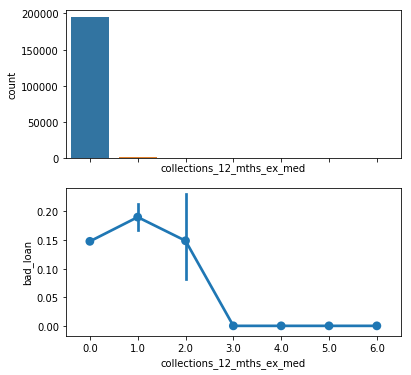

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
sns.countplot(x=col, data=clean_df, order=None, ax=ax1)
sns.pointplot(x=col, y='bad_loan', data=clean_df, order=None, ax=ax2)

In [24]:
# Fill with median which is 0
col = 'collections_12_mths_ex_med'
clean_df[col] = clean_df[col].fillna(0)

### Loan grade given by LendingClub
The categories used by LendingClub for their internal prediction of lending risk. Using one-hot-encoding.

B    69261
C    49997
A    41440
D    27090
E     7130
F     1556
G      184
Name: grade, dtype: int64


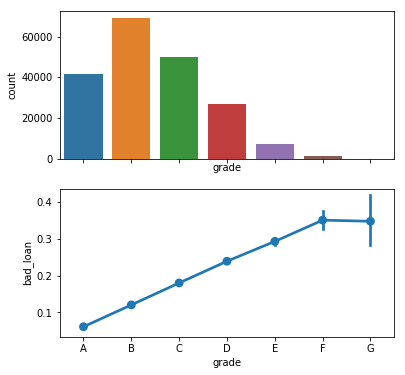

In [25]:
col = 'grade'
order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
print df[col].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
sns.countplot(x=col, data=clean_df, order=order, ax=ax1)
sns.pointplot(x=col, y='bad_loan', data=clean_df, order=order, ax=ax2)

In [29]:
clean_df = pd.get_dummies(clean_df, columns=[col])

### Purpose of loan

The borrower-selected reason for taking out the loan. Using one-hot-encoding.

debt_consolidation    111956
credit_card            41011
other                  11702
home_improvement       11181
major_purchase          5157
small_business          3608
car                     2909
medical                 2420
moving                  1793
wedding                 1694
vacation                1484
house                   1214
educational              309
renewable_energy         220
Name: purpose, dtype: int64


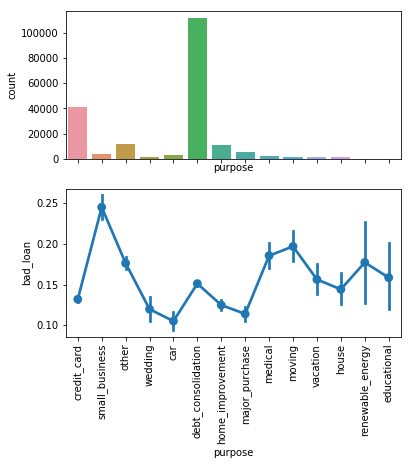

In [26]:
col = 'purpose'
order = None
print clean_df[col].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
sns.countplot(x=col, data=clean_df, order=order, ax=ax1)
sns.pointplot(x=col, y='bad_loan', data=clean_df, order=order, ax=ax2)
plt.xticks(rotation=90);

In [27]:
clean_df = pd.get_dummies(clean_df, columns=['purpose'])

### Number of years at current job

Convert from categories to numerical value. Convert n/a to 0 years.

10+ years    56522
2 years      18933
< 1 year     16957
3 years      16289
5 years      14155
1 year       13724
4 years      12969
6 years      11544
7 years      10795
8 years       9056
n/a           8515
9 years       7199
Name: emp_length, dtype: int64


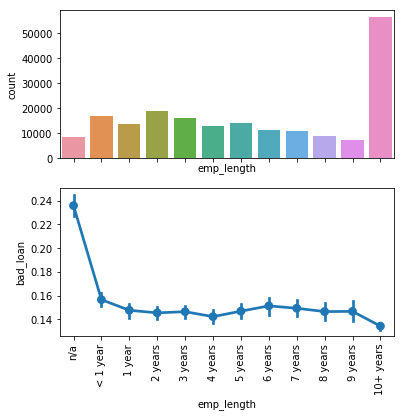

In [28]:
col = 'emp_length'
order = [
    'n/a', '< 1 year', '1 year', '2 years', '3 years' , '4 years', '5 years', 
    '6 years', '7 years', '8 years', '9 years', '10+ years']
print clean_df[col].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
sns.countplot(x=col, data=clean_df, order=order, ax=ax1)
sns.pointplot(x=col, y='bad_loan', data=clean_df, order=order, ax=ax2)
plt.xticks(rotation=90);

In [29]:
col = 'emp_length'
replace_dict = {'n/a':0, '< 1 year':0.5, '1 year':1, '2 years':2, 
                '3 years':3 , '4 years':4, '5 years':5, '6 years':6, 
                '7 years':7, '8 years':8, '9 years':9, '10+ years':10}
clean_df = clean_df.replace({col: replace_dict})

### Home ownership

There are a small number borrowers with odd categories (not 'RENT', 'MORTGAGE', or 'OWN). Group them as 'OTHER', then use one-hot-encoding.

In [31]:
col = 'home_ownership'
print clean_df[col].value_counts()

MORTGAGE    91585
RENT        87580
OWN         17317
OTHER         137
NONE           38
ANY             1
Name: home_ownership, dtype: int64


In [32]:
# Replace any of the odd categories with 'OTHER'
others = clean_df[col].isin(['OTHER', 'NONE', 'ANY'])
clean_df.loc[others, col] = 'OTHER'

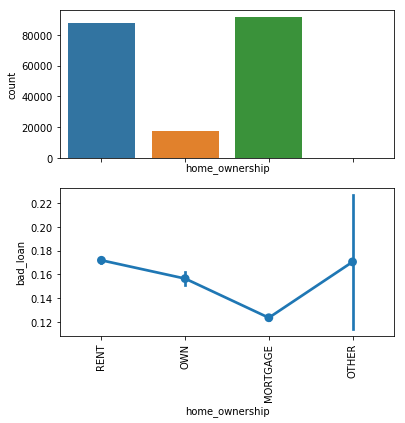

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
sns.countplot(x=col, data=clean_df, order=None, ax=ax1)
sns.pointplot(x=col, y='bad_loan', data=clean_df, order=None, ax=ax2)
plt.xticks(rotation=90);

In [34]:
clean_df = pd.get_dummies(clean_df, columns=[col])

### Borrower's state
Where the borrower lives. Using one-hot-encoding.

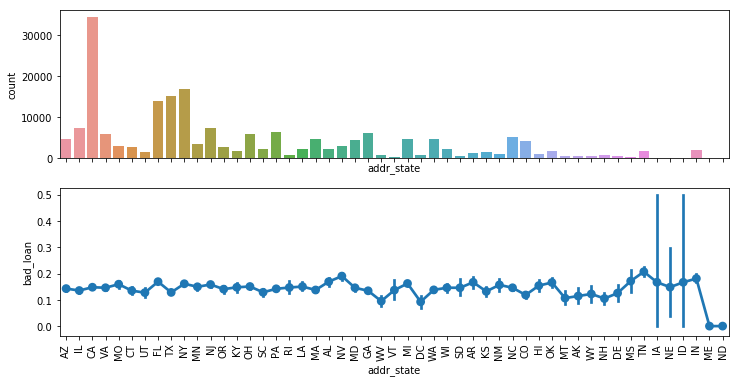

In [36]:
col = 'addr_state'
order = None
#print clean_df[col].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
sns.countplot(x=col, data=clean_df, order=order, ax=ax1)
sns.pointplot(x=col, y='bad_loan', data=clean_df, order=order, ax=ax2)
plt.xticks(rotation=90);

In [37]:
clean_df = pd.get_dummies(clean_df, columns=['addr_state'])

# Check for remaining missing data

In [38]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196658 entries, 0 to 887371
Data columns (total 93 columns):
bad_loan                      196658 non-null int64
grade                         196658 non-null object
annual_inc                    196658 non-null float64
emp_length                    196658 non-null float64
dti                           196658 non-null float64
delinq_2yrs                   196658 non-null float64
inq_last_6mths                196658 non-null float64
mths_since_last_delinq        196658 non-null float64
open_acc                      196658 non-null float64
pub_rec                       196658 non-null float64
revol_bal                     196658 non-null float64
revol_util                    196658 non-null float64
total_acc                     196658 non-null float64
collections_12_mths_ex_med    196658 non-null float64
acc_now_delinq                196658 non-null float64
tot_coll_amt                  196658 non-null float64
tot_cur_bal                 

In [40]:
# Check if there are any null values
clean_df.isnull().values.any()

False

In [41]:
print clean_df.shape
clean_df.head(3)

(196658, 93)


,bad_loan,grade,annual_inc,emp_length,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_amnt,int_rate,installment,issue_d,total_rec_prncp,total_rec_int,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,0,B,24000.0,10.0,27.65,0.0,1.0,33.0,3.0,0.0,13648.0,83.7,9.0,0.0,0.0,0.0,66863.5,20900.0,5000.0,10.65,162.87,2011-12-01,5000.0,861.07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,C,12252.0,10.0,8.72,0.0,2.0,33.0,2.0,0.0,2956.0,98.5,10.0,0.0,0.0,0.0,66863.5,20900.0,2400.0,15.96,84.33,2011-12-01,2400.0,603.65,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,C,49200.0,10.0,20.00,0.0,1.0,35.0,10.0,0.0,5598.0,21.0,37.0,0.0,0.0,0.0,66863.5,20900.0,10000.0,13.49,339.31,2011-12-01,10000.0,2209.33,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Save the cleaned data

In [43]:
clean_df.to_csv('loan_clean.csv', index=False)